In [1]:
import tensorflow as tf
from urllib.request import urlretrieve
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from IPython import display
from tqdm.notebook import tqdm, tnrange
from tensorflow.keras import models, layers, activations
from tensorflow.keras.models import Model, Sequential

In [2]:
url =  'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
urlretrieve(url,'cifar-10')

('cifar-10', <http.client.HTTPMessage at 0x7fb865beb2d0>)

In [3]:
!tar -xvf cifar-10

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
batch1 = unpickle('/content/cifar-10-batches-py/data_batch_1')
batch2 = unpickle('/content/cifar-10-batches-py/data_batch_1')
batch3 = unpickle('/content/cifar-10-batches-py/data_batch_1')
batch4 = unpickle('/content/cifar-10-batches-py/data_batch_1')
batch5 = unpickle('/content/cifar-10-batches-py/data_batch_1')
batchtest = unpickle('/content/cifar-10-batches-py/test_batch')
batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [6]:
def load_data():
  # build data set
  train_set = np.concatenate((batch1[b'data'], batch2[b'data'],
                            batch3[b'data'], batch4[b'data'],
                            batch5[b'data']), axis=0)
  # build label set
  train_label = (batch1[b'labels'] + batch2[b'labels'] + batch3[b'labels'] +
                batch4[b'labels'] + batch5[b'labels'])
  test_set=batchtest[b'data']
  # return data sets to np array
  train_set = np.array(train_set)
  train_label = np.array(train_label)
  test_set = np.array(test_set)

  print(f'before reshaping Train_set shape is: {train_set.shape}\nTest_set shape is: {test_set.shape}\n')

  # reshape data sets to ideal shape
  train_set = train_set.reshape(50000, 32, 32, 3)
  test_set = test_set.reshape(10000, 32, 32, 3)

  print(f'after reshaping Train_set shape is: {train_set.shape}\nTest_set shape is: {test_set.shape}\n')

  # train-val split
  train_x = train_set[0:40000]
  train_y = train_label[0:40000]
  val_x = train_set[40000:]
  val_y = train_label[40000:]

  # scale data
  train_x = train_x/255.0
  val_x = val_x/255.0
  test_x = test_set/255.0

  print(f'Train_x shape is: {train_x.shape}\nTrain_y shape is: {train_y.shape}\nVal_x shape is: {val_x.shape}\nVal_y shape is: {val_y.shape}\nTest_x shape is: {test_x.shape}\n')

  return train_x, train_y, val_x, val_y, test_x

In [7]:
def one_hot(train_y, val_y):
  print(f'before one hot Train_y shape: {train_y.shape}\nVal_y shape: {val_y.shape}\n')
  train_y_one_hot = tf.keras.utils.to_categorical(train_y, num_classes=10, dtype='float32')
  val_y_one_hot = tf.keras.utils.to_categorical(val_y, num_classes=10, dtype='float32')
  print(f'after one hot Train_y shape: {train_y_one_hot.shape}\nVal_y shape: {val_y_one_hot.shape}')
  return train_y_one_hot, val_y_one_hot

In [8]:
def build_nueral_network():

  input = layers.Input(shape=(32, 32, 3))

  layer1 = layers.BatchNormalization()(input)
  layer2 = layers.Conv2D(64, kernel_size=(5,5), activation='relu', padding='same')(layer1)
  layer3 = layers.BatchNormalization()(layer2)
  layer4 = layers.MaxPooling2D(pool_size=(2,2))(layer3)
  layer5 = layers.Dropout(0.2)(layer4)

  layer6 = layers.BatchNormalization()(layer5)
  layer7 = layers.Conv2D(64, kernel_size=(5,5), activation='relu')(layer6)
  layer8 = layers.BatchNormalization()(layer7)
  layer9 = layers.MaxPooling2D(pool_size=(2,2))(layer8)
  layer10 = layers.Dropout(0.2)(layer9)

  layer11 = layers.BatchNormalization()(layer10)
  layer12 = layers.Conv2D(64, kernel_size=(3,3), activation='relu')(layer11)
  layer13 = layers.BatchNormalization()(layer12)
  layer14 = layers.MaxPooling2D(pool_size=(2,2))(layer13)
  layer15 = layers.Dropout(0.2)(layer14)

  layer16 = layers.Flatten()(layer15)
  layer17 = layers.Dropout(0.25)(layer16)
  layer18 = layers.BatchNormalization()(layer17)
  layer19 = layers.Dense(120, activation='relu')(layer18)
  layer20 = layers.Dense(80, activation='relu')(layer19)

  output = layers.Dense(10, activation='softmax')(layer20)

  model = Model(inputs=input, outputs=output)
  print(model.summary())

  return model

In [9]:
def compile_model(model, learning_rate=0.001):
  loss = 'CategoricalCrossentropy' 
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  metrics = ['acc']
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [10]:
def fit_model(model, train_x, train_y, val_x, val_y, n_epochs, batch_size):
  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []

  best_validation_accuracy = 0

  for epoch in range(n_epochs):
    st = time.time()
    history = model.fit(train_x, train_y, batch_size=batch_size)
    trainloss = history.history['loss']
    trainacc = history.history['acc']
    train_loss.append(trainloss)
    train_acc.append(trainacc)

    scores = model.evaluate(x=val_x, y=val_y, batch_size=5)
    valloss = scores[0]
    valacc = scores[1]
    val_loss.append(valloss)
    val_acc.append(valacc)

    if valacc > best_validation_accuracy:
      best_validation_accuracy = valacc
    
    fig = plt.figure(figsize=(9, 6))
    train_loss_plt, = plt.plot(range(len(train_loss)), train_loss, 'r', label='train_loss')
    train_acc_plt, = plt.plot(range(len(train_acc)), train_acc, 'g', label='train_acc')
    val_loss_plr, = plt.plot(range(len(val_loss)), val_loss, alpha=0.3, color='r', label='val_loss')
    val_acc_plt, = plt.plot(range(len(val_acc)), val_acc, alpha=0.3, color='g', label='val_acc')
    plt.legend([train_loss_plt, train_acc_plt, val_loss_plr, val_acc_plt],
               ['training loss', 'training accuracy', 'validation loss', 'validation accuracy'],
               loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Best validation accuracy = {:.2f}%'.format(100. * best_validation_accuracy))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(.2)

In [11]:
train_x, train_y, val_x, val_y, test_x = load_data()
train_y, val_y = one_hot(train_y, val_y)

before reshaping Train_set shape is: (50000, 3072)
Test_set shape is: (10000, 3072)

after reshaping Train_set shape is: (50000, 32, 32, 3)
Test_set shape is: (10000, 32, 32, 3)

Train_x shape is: (40000, 32, 32, 3)
Train_y shape is: (40000,)
Val_x shape is: (10000, 32, 32, 3)
Val_y shape is: (10000,)
Test_x shape is: (10000, 32, 32, 3)

before one hot Train_y shape: (40000,)
Val_y shape: (10000,)

after one hot Train_y shape: (40000, 10)
Val_y shape: (10000, 10)


In [12]:
model = build_nueral_network()
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                             

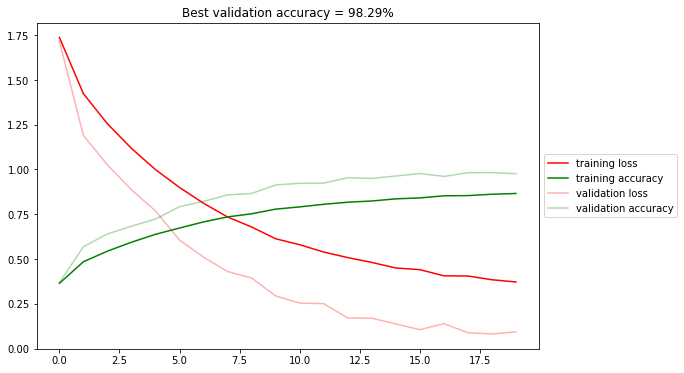

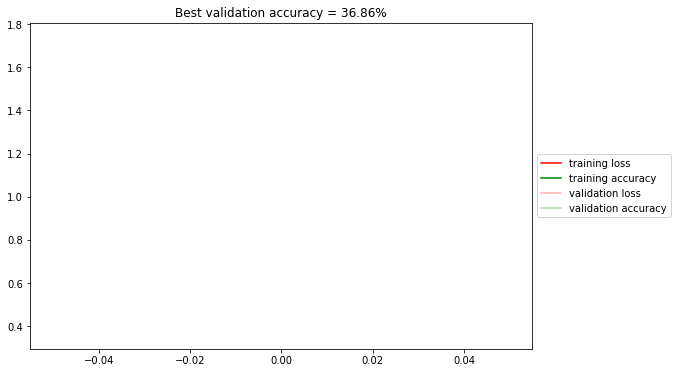

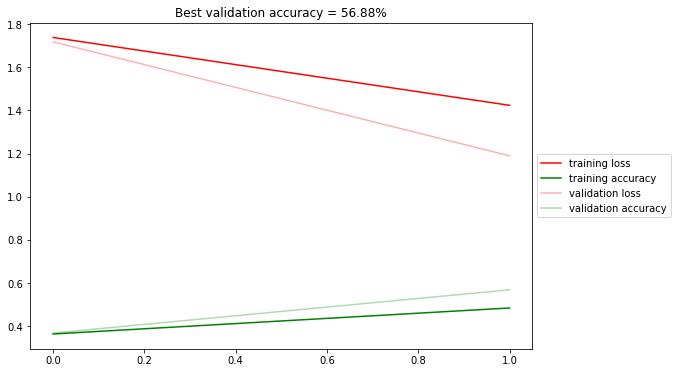

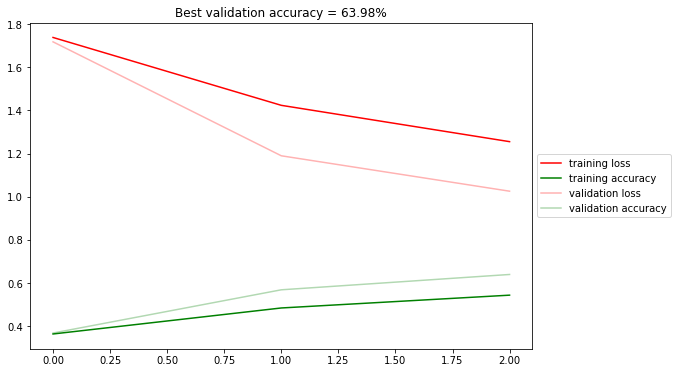

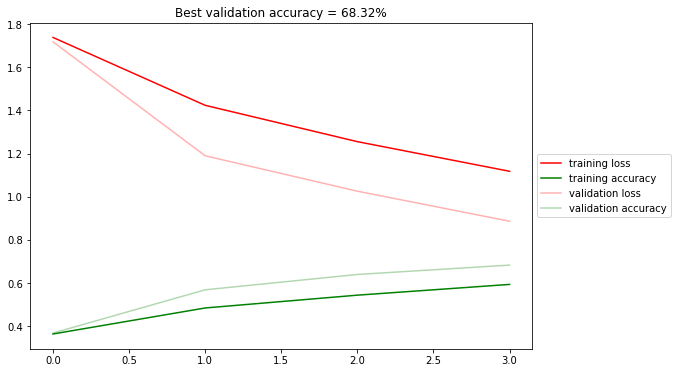

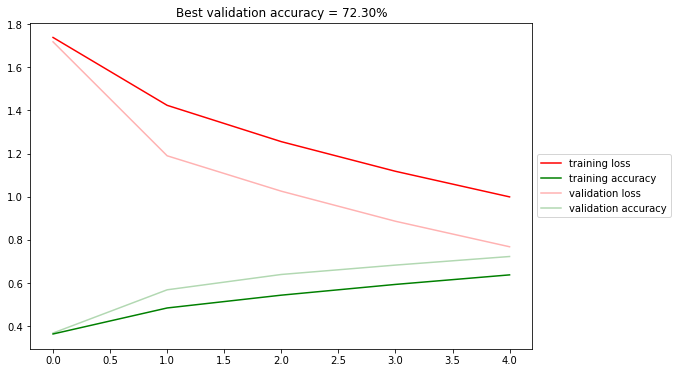

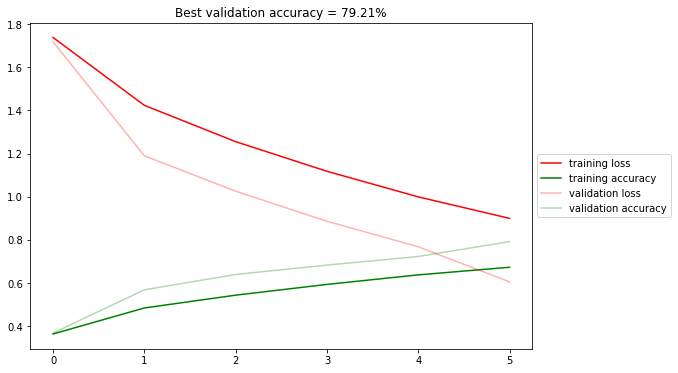

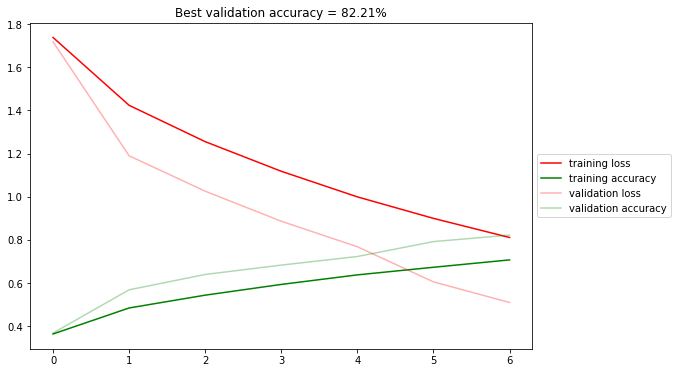

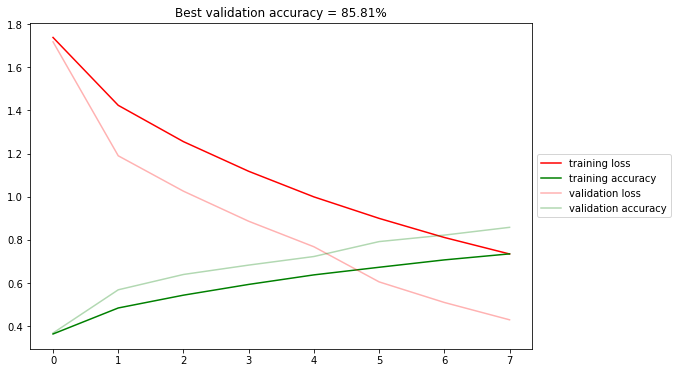

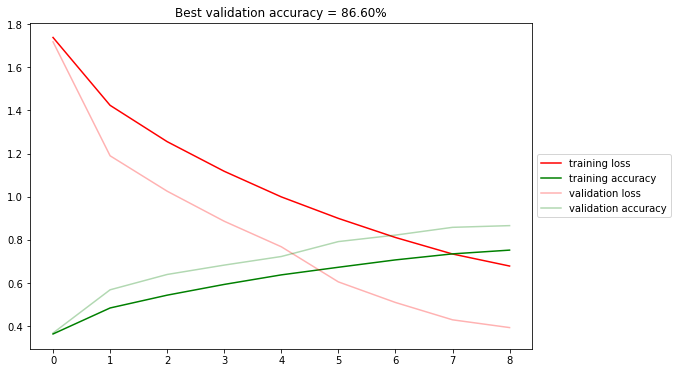

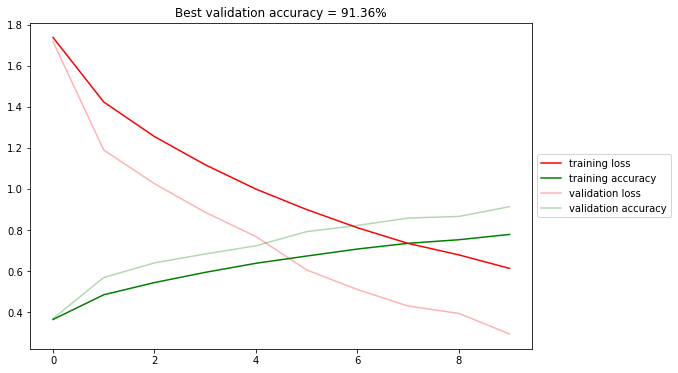

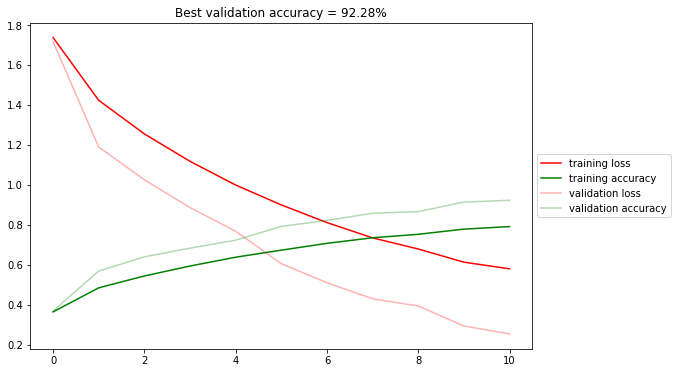

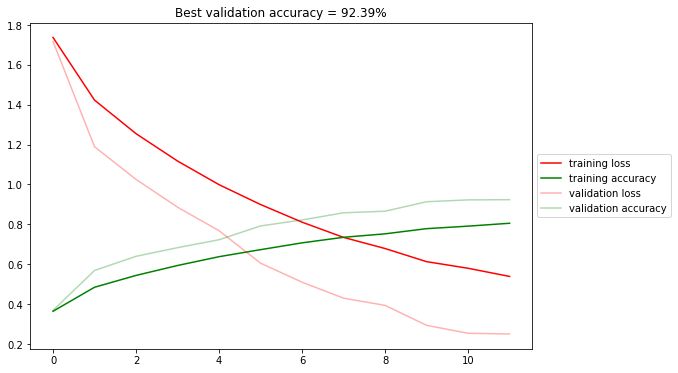

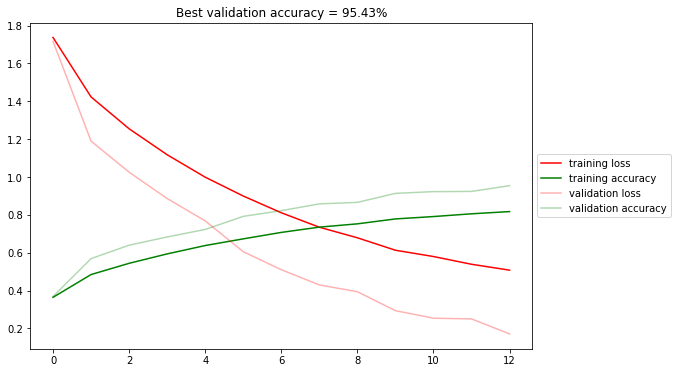

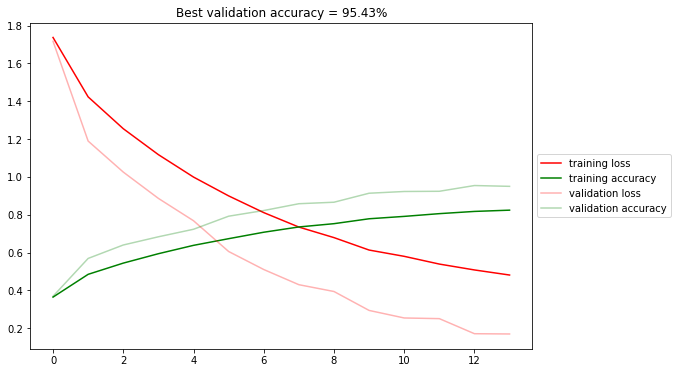

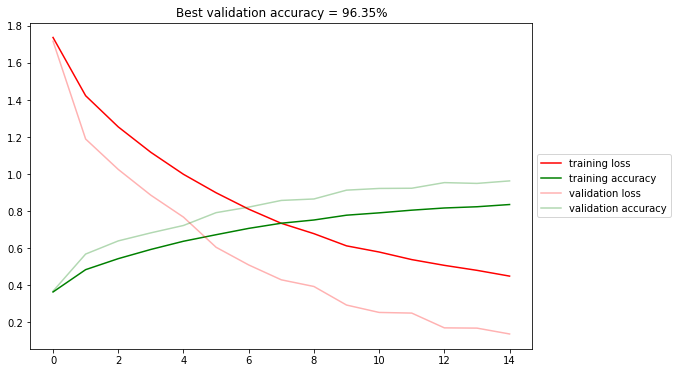

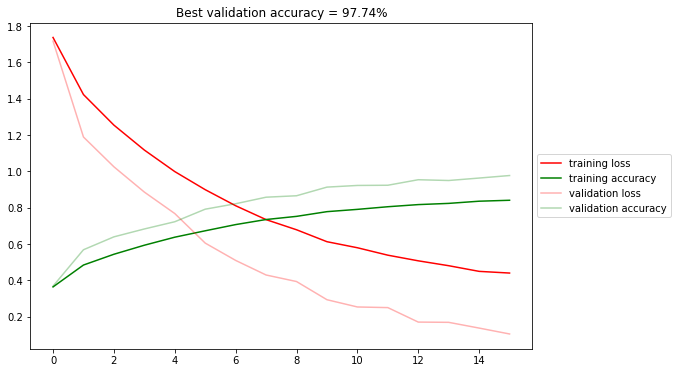

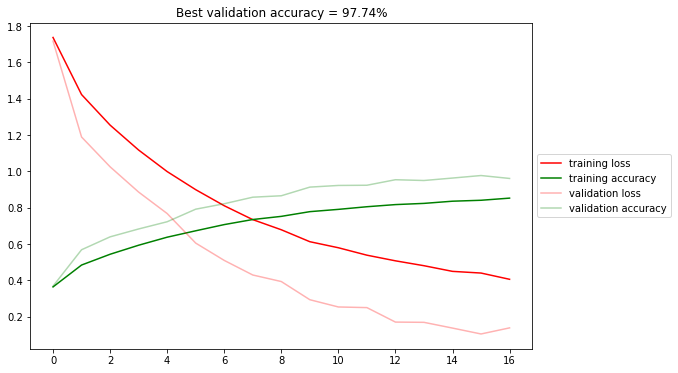

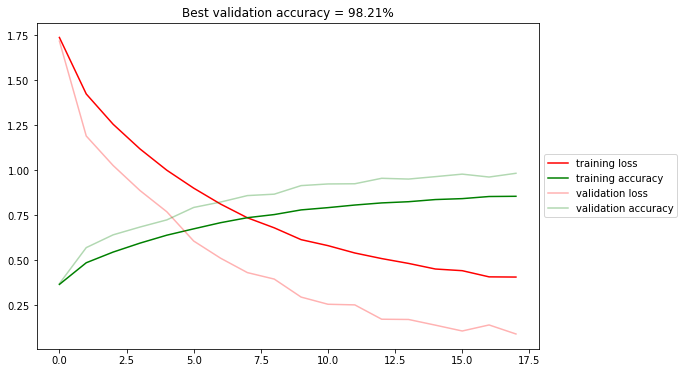

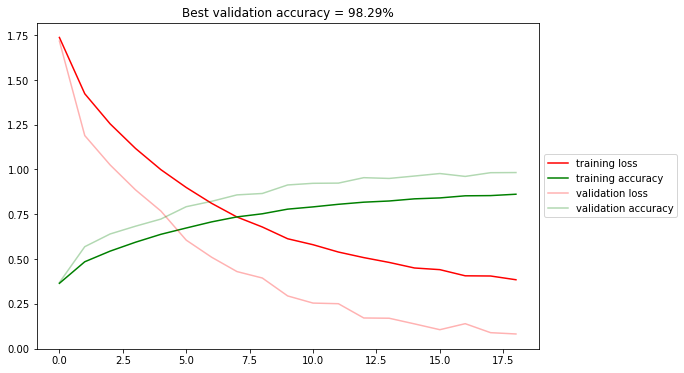

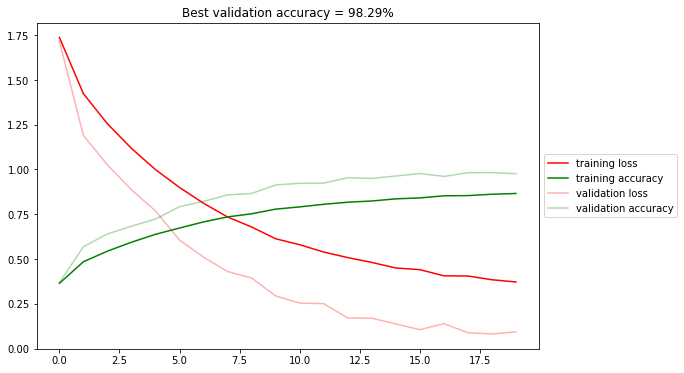

In [13]:
fit_model(model, train_x, train_y, val_x, val_y, n_epochs=20, batch_size=128)